In [3]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=1.2)
sns.set_style("white")

# Load data
df = pd.read_csv("../data/merged_with_property.csv", low_memory=False)

# Exchange rates
DKK_TO_EUR = 0.134
NOK_TO_EUR = 0.085

# Convert prices to EUR
df['price_eur'] = df.apply(
    lambda row: row['price_local'] * DKK_TO_EUR if row['city'] == 'Copenhagen'
    else row['price_local'] * NOK_TO_EUR, axis=1
)

# Filter data
dk_data = df[df['city'] == 'Copenhagen']['price_eur'].dropna()
no_data = df[df['city'] == 'Oslo']['price_eur'].dropna()

print(f"Copenhagen: n={len(dk_data)}, mean={dk_data.mean():.2f} EUR, std={dk_data.std():.2f} EUR")
print(f"Oslo: n={len(no_data)}, mean={no_data.mean():.2f} EUR, std={no_data.std():.2f} EUR")

Copenhagen: n=13831, mean=190.00 EUR, std=208.58 EUR
Oslo: n=8701, mean=142.40 EUR, std=275.82 EUR


In [4]:
# Bayesian inference function
def calculate_posterior(price_data, prior_mu=150, prior_tau=100):
    n = len(price_data)
    data_mu = price_data.mean()
    data_sigma = price_data.std()
    
    precision_prior = 1 / (prior_tau**2)
    precision_data = n / (data_sigma**2)
    
    post_mu = (prior_mu * precision_prior + data_mu * precision_data) / (precision_prior + precision_data)
    post_tau = np.sqrt(1 / (precision_prior + precision_data))
    
    return post_mu, post_tau

# Calculate posteriors
mu_cph, tau_cph = calculate_posterior(dk_data, prior_mu=150, prior_tau=100)
mu_oslo, tau_oslo = calculate_posterior(no_data, prior_mu=150, prior_tau=100)

ci_cph = stats.norm.interval(0.95, loc=mu_cph, scale=tau_cph)
ci_oslo = stats.norm.interval(0.95, loc=mu_oslo, scale=tau_oslo)

# Mean difference
mu_delta = mu_cph - mu_oslo
tau_delta = np.sqrt(tau_cph**2 + tau_oslo**2)
ci_delta = stats.norm.interval(0.95, loc=mu_delta, scale=tau_delta)
prob_cph_higher = 1 - stats.norm.cdf(0, loc=mu_delta, scale=tau_delta)

# Print results
print("="*60)
print("BAYESIAN POSTERIOR ESTIMATES (EUR)")
print("="*60)
print("Copenhagen:")
print(f"Posterior Mean: {mu_cph:.2f} EUR")
print(f"95% CI: ({ci_cph[0]:.2f}, {ci_cph[1]:.2f}) EUR")
print("")
print("Oslo:")
print(f"Posterior Mean: {mu_oslo:.2f} EUR")
print(f"95% CI: ({ci_oslo[0]:.2f}, {ci_oslo[1]:.2f}) EUR")
print("")
print("Mean Difference (Copenhagen - Oslo):")
print(f"Posterior Mean: {mu_delta:.2f} EUR")
print(f"95% CI: ({ci_delta[0]:.2f}, {ci_delta[1]:.2f}) EUR")
print(f"P(Copenhagen > Oslo): {prob_cph_higher:.6f}")
print("="*60)

BAYESIAN POSTERIOR ESTIMATES (EUR)
Copenhagen:
Posterior Mean: 189.98 EUR
95% CI: (186.51, 193.46) EUR

Oslo:
Posterior Mean: 142.41 EUR
95% CI: (136.61, 148.20) EUR

Mean Difference (Copenhagen - Oslo):
Posterior Mean: 47.58 EUR
95% CI: (40.82, 54.33) EUR
P(Copenhagen > Oslo): 1.000000


In [5]:
# Prior sensitivity analysis
print("="*60)
print("PRIOR SENSITIVITY ANALYSIS")
print("="*60)
print(f"{'tau0':<12} {'mean_diff':<12} {'CI_lower':<12} {'CI_upper':<12} {'P(diff>0)':<12}")
print("-"*60)

tau0_list = [50, 100, 200, 500]
for tau0 in tau0_list:
    mu_cph_s, tau_cph_s = calculate_posterior(dk_data, prior_mu=150, prior_tau=tau0)
    mu_oslo_s, tau_oslo_s = calculate_posterior(no_data, prior_mu=150, prior_tau=tau0)
    
    mu_diff_s = mu_cph_s - mu_oslo_s
    tau_diff_s = np.sqrt(tau_cph_s**2 + tau_oslo_s**2)
    ci_diff_s = stats.norm.interval(0.95, loc=mu_diff_s, scale=tau_diff_s)
    prob_s = 1 - stats.norm.cdf(0, loc=mu_diff_s, scale=tau_diff_s)
    
    print(f"{tau0:<12} {mu_diff_s:<12.2f} {ci_diff_s[0]:<12.2f} {ci_diff_s[1]:<12.2f} {prob_s:<12.6f}")

print("="*60)

PRIOR SENSITIVITY ANALYSIS
tau0         mean_diff    CI_lower     CI_upper     P(diff>0)   
------------------------------------------------------------
50           47.52        40.77        54.27        1.000000    
100          47.58        40.82        54.33        1.000000    
200          47.59        40.83        54.35        1.000000    
500          47.60        40.84        54.35        1.000000    


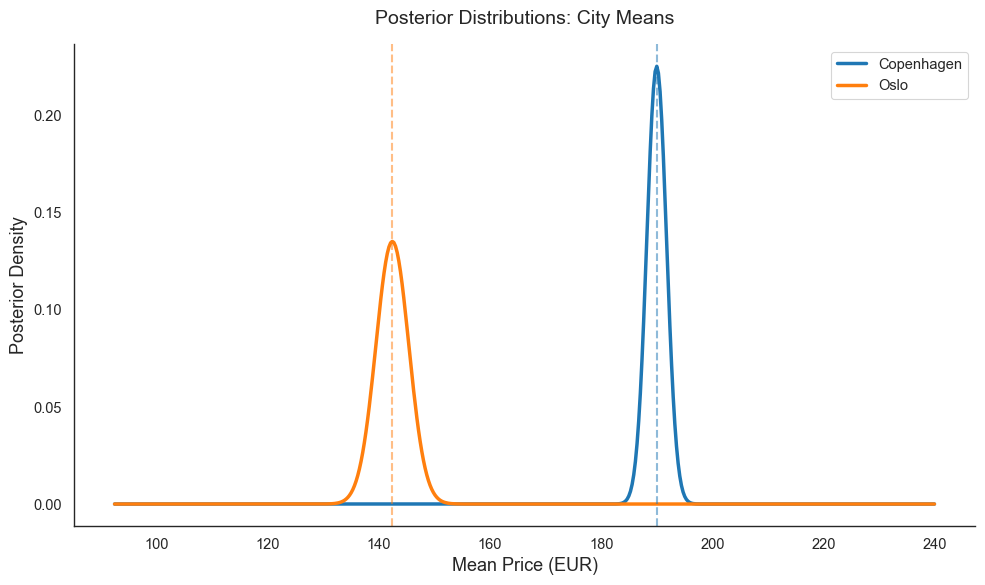

In [6]:
# Plot 1: Posterior distributions for each city
plt.figure(figsize=(10, 6))

x_range = np.linspace(min(mu_cph, mu_oslo) - 50, max(mu_cph, mu_oslo) + 50, 500)
plt.plot(x_range, stats.norm.pdf(x_range, mu_cph, tau_cph), 
         label='Copenhagen', linewidth=2.5, color='#1f77b4')
plt.plot(x_range, stats.norm.pdf(x_range, mu_oslo, tau_oslo), 
         label='Oslo', linewidth=2.5, color='#ff7f0e')
plt.axvline(mu_cph, color='#1f77b4', linestyle='--', alpha=0.5, linewidth=1.5)
plt.axvline(mu_oslo, color='#ff7f0e', linestyle='--', alpha=0.5, linewidth=1.5)

plt.xlabel('Mean Price (EUR)', fontsize=13)
plt.ylabel('Posterior Density', fontsize=13)
plt.title('Posterior Distributions: City Means', fontsize=14, pad=15)
plt.legend(loc='upper right')
sns.despine()
plt.tight_layout()
plt.savefig('posterior_city_means.png', dpi=300, bbox_inches='tight')
plt.show()

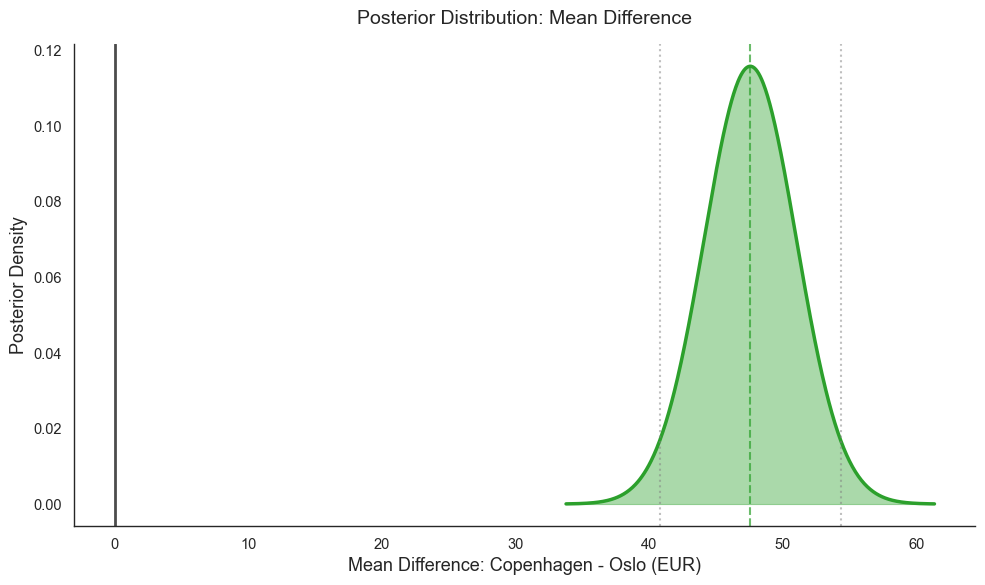

In [7]:
# Plot 2: Posterior distribution for the difference
plt.figure(figsize=(10, 6))

delta_range = np.linspace(mu_delta - 4*tau_delta, mu_delta + 4*tau_delta, 500)
plt.fill_between(delta_range, stats.norm.pdf(delta_range, mu_delta, tau_delta), 
                 alpha=0.4, color='#2ca02c')
plt.plot(delta_range, stats.norm.pdf(delta_range, mu_delta, tau_delta), 
         linewidth=2.5, color='#2ca02c')
plt.axvline(0, color='black', linestyle='-', linewidth=2, alpha=0.7)
plt.axvline(mu_delta, color='#2ca02c', linestyle='--', linewidth=1.5, alpha=0.7)
plt.axvline(ci_delta[0], color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
plt.axvline(ci_delta[1], color='gray', linestyle=':', linewidth=1.5, alpha=0.5)

plt.xlabel('Mean Difference: Copenhagen - Oslo (EUR)', fontsize=13)
plt.ylabel('Posterior Density', fontsize=13)
plt.title('Posterior Distribution: Mean Difference', fontsize=14, pad=15)
sns.despine()
plt.tight_layout()
plt.savefig('posterior_difference.png', dpi=300, bbox_inches='tight')
plt.show()

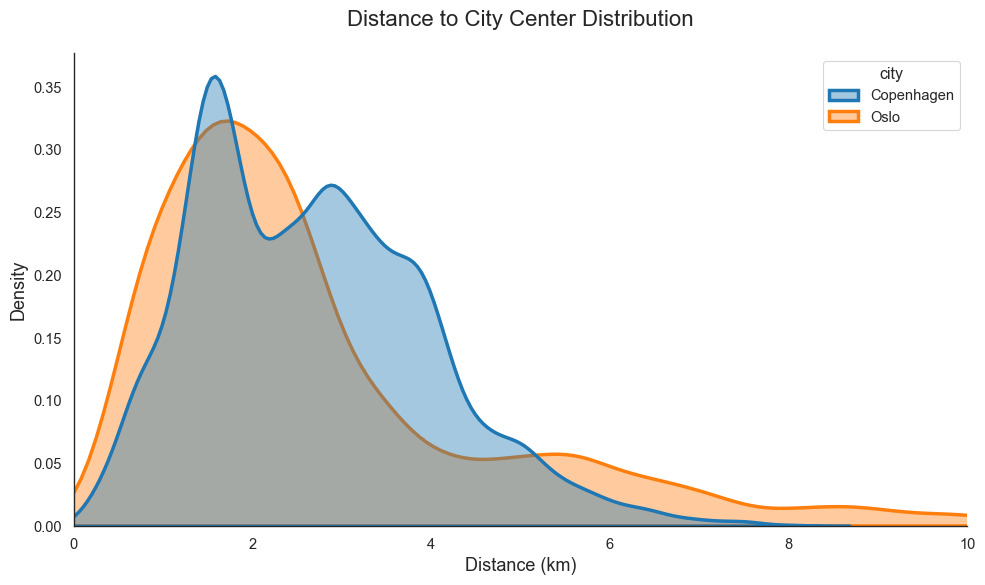

In [8]:
# Plot 3: Distance to center distribution
df_sub = df[df['city'].isin(['Copenhagen', 'Oslo'])].copy()

plt.figure(figsize=(10, 6))
sns.kdeplot(
    data=df_sub, 
    x='distance_to_center_km', 
    hue='city', 
    fill=True, 
    common_norm=False, 
    palette={'Copenhagen': '#1f77b4', 'Oslo': '#ff7f0e'},
    alpha=0.4, 
    linewidth=2.5
)

plt.title('Distance to City Center Distribution', fontsize=16, pad=20)
plt.xlabel('Distance (km)', fontsize=13)
plt.ylabel('Density', fontsize=13)
plt.xlim(0, 10)
sns.despine()
plt.tight_layout()
plt.savefig('distance_distribution_clean.png', dpi=300, bbox_inches='tight')
plt.show()